In [1]:
from Trainmodel import traindcnncoxmodel,traincnncoxmodel
from utils import avgcindex

2024-04-11 14:19:16.960059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import numpy as np
import pandas as pd
#from model import cnncox,dcnncox,nncox
from earlystoping import MyCallback
from utils import nll,avgcindex,setup_seed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Dropout,Input,Flatten,concatenate
from tensorflow.keras.regularizers import l2

In [3]:

conv1_size=(1, 10)
conv2_size=(10, 1)
input_shape = (10, 10, 1)
le, wi = 10,10


seed=42

cancer_name='LGG'
Cindex=[]

current_path='../data/100'
output_path=current_path+'/' + cancer_name + "100.csv"
save_path="../save model/100/my1DCNNCox/"
os.makedirs(save_path,exist_ok=True)





setup_seed(seed)

df_exp=pd.read_csv(output_path,index_col=0)
gene_exp=df_exp.dropna(axis=0,subset = ["OS", "OS.time"])
E=np.array(gene_exp["OS"])
Y=np.array(gene_exp["OS.time"])

In [4]:
E.shape

(514,)

In [5]:
E[0:15]

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])

In [6]:
Y.shape

(514,)

In [7]:
Y[0:15]

array([ 709.,  523.,  112., 1762., 2918.,  532.,   76.,  368.,  372.,
        758.,  623., 2381.,  204.,  354., 1354.])

In [8]:
X=np.array(gene_exp)

In [9]:
X.shape

(514, 102)

In [10]:
X[0:5,0:5]

array([[1.0000e+00, 7.0900e+02, 4.4496e+00, 4.0985e+00, 2.0183e+00],
       [0.0000e+00, 5.2300e+02, 5.5895e+00, 3.5473e+00, 1.6785e+00],
       [0.0000e+00, 1.1200e+02, 5.9074e+00, 3.3435e+00, 3.0270e+00],
       [1.0000e+00, 1.7620e+03, 4.2593e+00, 2.9032e+00, 6.8800e-01],
       [0.0000e+00, 2.9180e+03, 5.9014e+00, 3.6417e+00, 3.1955e+00]])

In [11]:
X=X.astype('float64')

In [12]:
X.shape

(514, 102)

In [13]:
X[0:5,0:5]

array([[1.0000e+00, 7.0900e+02, 4.4496e+00, 4.0985e+00, 2.0183e+00],
       [0.0000e+00, 5.2300e+02, 5.5895e+00, 3.5473e+00, 1.6785e+00],
       [0.0000e+00, 1.1200e+02, 5.9074e+00, 3.3435e+00, 3.0270e+00],
       [1.0000e+00, 1.7620e+03, 4.2593e+00, 2.9032e+00, 6.8800e-01],
       [0.0000e+00, 2.9180e+03, 5.9014e+00, 3.6417e+00, 3.1955e+00]])

In [14]:
# Remove the first two columns (OS and OS.time)
X=X[:,2:]

In [15]:
X.shape

(514, 100)

In [16]:
X[0:5,0:5]

array([[4.4496, 4.0985, 2.0183, 1.0642, 2.874 ],
       [5.5895, 3.5473, 1.6785, 1.7532, 1.9564],
       [5.9074, 3.3435, 3.027 , 2.4359, 3.97  ],
       [4.2593, 2.9032, 0.688 , 1.4065, 1.0503],
       [5.9014, 3.6417, 3.1955, 4.6949, 1.5316]])

In [17]:
scaler=StandardScaler().fit(X)

In [18]:
X[0:5,0:5]

array([[4.4496, 4.0985, 2.0183, 1.0642, 2.874 ],
       [5.5895, 3.5473, 1.6785, 1.7532, 1.9564],
       [5.9074, 3.3435, 3.027 , 2.4359, 3.97  ],
       [4.2593, 2.9032, 0.688 , 1.4065, 1.0503],
       [5.9014, 3.6417, 3.1955, 4.6949, 1.5316]])

In [19]:
X=scaler.transform(X)

In [20]:
X[0:5,0:5]

array([[-0.54960966,  0.29284883, -0.51964768, -0.45117084,  1.20086852],
       [ 0.6521546 , -0.21538826, -0.78101813, -0.07715054,  0.62943384],
       [ 0.98730756, -0.40330321,  0.25623334,  0.29344983,  1.88340167],
       [-0.75023755, -0.80928433, -1.5428999 , -0.26535495,  0.06516077],
       [ 0.98098193, -0.12834621,  0.3858417 ,  1.519737  ,  0.36488997]])

In [21]:
X.shape

(514, 100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 10, 1, 128)        1408      
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 1, 128)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 128)               82048     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

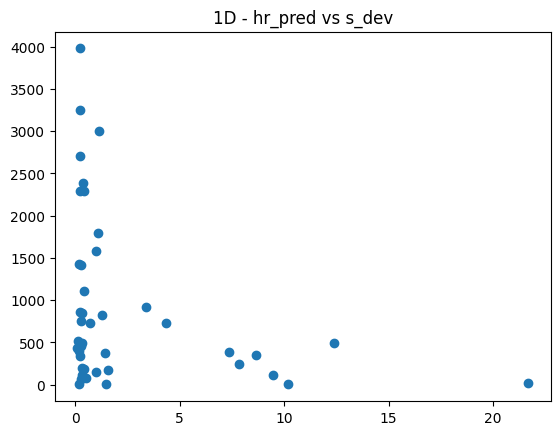

[[ 0.24057822]
 [ 0.20565271]
 [ 0.20558193]
 [ 0.6084631 ]
 [ 0.14035556]
 [ 0.12626185]
 [ 0.34638312]
 [ 0.27726224]
 [ 0.23979178]
 [ 7.1370716 ]
 [ 0.10579265]
 [ 0.15346986]
 [ 0.40329754]
 [ 0.41990945]
 [ 0.36362717]
 [ 0.17678478]
 [ 0.344229  ]
 [ 0.22133571]
 [ 0.66844755]
 [ 0.34690672]
 [ 1.0178931 ]
 [ 0.2113504 ]
 [ 0.4924605 ]
 [ 0.95587665]
 [ 0.1302566 ]
 [ 0.3234442 ]
 [ 6.163239  ]
 [ 0.23007002]
 [ 0.93309224]
 [ 0.37890556]
 [ 0.18956445]
 [ 3.6734946 ]
 [ 0.2743309 ]
 [ 0.4657499 ]
 [ 0.19423737]
 [ 0.15035345]
 [ 0.6728964 ]
 [ 0.4944546 ]
 [ 0.22077094]
 [ 0.60417265]
 [11.863753  ]
 [ 0.64879876]
 [ 0.18520017]
 [ 0.18886966]
 [ 0.1808084 ]
 [ 8.972533  ]
 [ 0.17963588]
 [ 2.7441194 ]
 [ 3.5782104 ]
 [ 2.2748928 ]
 [ 0.32693046]
 [ 0.5895885 ]
 [ 5.9757953 ]
 [ 1.9317153 ]
 [ 0.21144664]
 [16.008808  ]
 [13.469799  ]
 [ 0.53892595]
 [ 0.66995454]
 [ 0.269     ]
 [ 0.22282666]
 [ 9.243183  ]
 [ 0.23839414]
 [ 0.3975009 ]
 [ 0.15630478]
 [ 7.151068  ]
 [ 0.15248

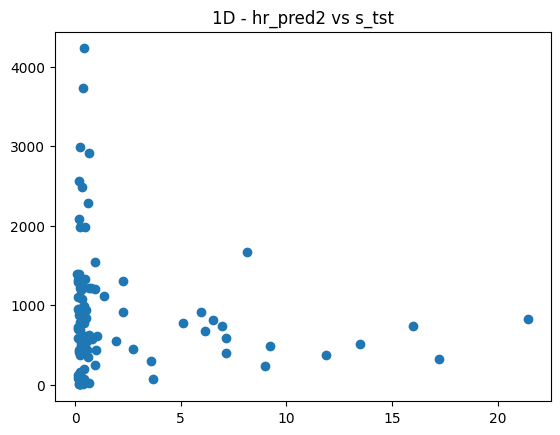

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 1, 128)        1408      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 1, 128)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               82048     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                           

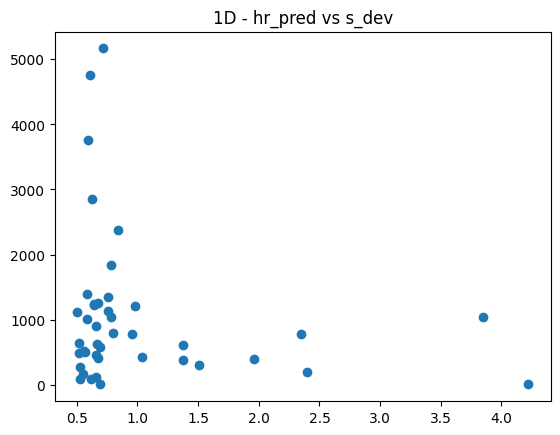

[[0.5216944 ]
 [1.8123608 ]
 [0.7634117 ]
 [0.79206246]
 [2.8839397 ]
 [0.47824585]
 [0.6746212 ]
 [1.1574748 ]
 [3.721867  ]
 [0.57138515]
 [0.6940345 ]
 [0.8607762 ]
 [0.61656606]
 [0.73218834]
 [0.72313094]
 [1.9684181 ]
 [1.865233  ]
 [0.74978584]
 [1.5973397 ]
 [0.7524852 ]
 [2.6622915 ]
 [1.582895  ]
 [2.770596  ]
 [0.77808666]
 [0.5614622 ]
 [0.5859455 ]
 [0.65601814]
 [0.87930626]
 [0.8091459 ]
 [2.5702386 ]
 [0.533071  ]
 [0.7846368 ]
 [0.6904793 ]
 [3.1274328 ]
 [0.86088485]
 [0.7096506 ]
 [2.3660986 ]
 [0.65442836]
 [0.72504115]
 [0.83543056]
 [1.5602226 ]
 [0.9852471 ]
 [4.3243785 ]
 [4.1063128 ]
 [0.48292723]
 [4.032861  ]
 [0.67590606]
 [0.59863055]
 [0.7164512 ]
 [3.4530978 ]
 [0.45617926]
 [0.65512556]
 [0.82391095]
 [0.605595  ]
 [3.6931078 ]
 [1.1582141 ]
 [1.6770194 ]
 [0.5721948 ]
 [0.515262  ]
 [0.5457324 ]
 [1.646352  ]
 [0.6683195 ]
 [0.9475324 ]
 [0.7123947 ]
 [1.0379955 ]
 [0.712894  ]
 [1.7363333 ]
 [0.6911805 ]
 [0.66420215]
 [2.6059976 ]
 [0.70588917]
 [0.72

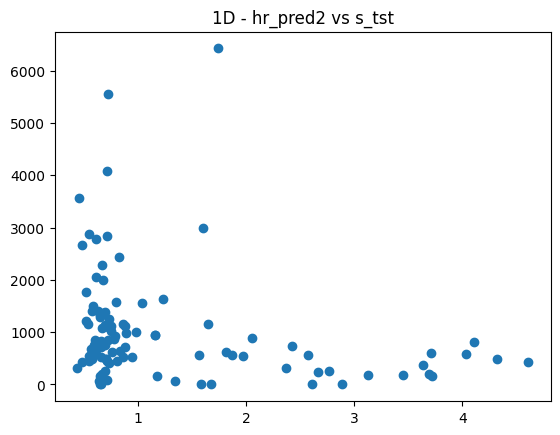

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 1, 128)        1408      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 1, 128)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 640)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               82048     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                           

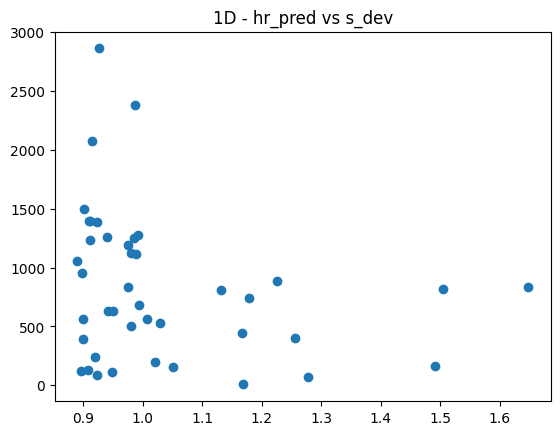

[[0.92494243]
 [1.4600545 ]
 [0.9403546 ]
 [1.5295383 ]
 [0.9270382 ]
 [1.3978349 ]
 [1.0040843 ]
 [0.99154294]
 [1.4026566 ]
 [1.2018813 ]
 [0.9523592 ]
 [0.9541133 ]
 [0.9629156 ]
 [0.87546986]
 [0.9360727 ]
 [0.8857226 ]
 [1.0464513 ]
 [0.8947211 ]
 [0.9340394 ]
 [0.91324496]
 [1.0131179 ]
 [0.9179049 ]
 [0.9048189 ]
 [1.3618734 ]
 [0.9851767 ]
 [1.4921398 ]
 [1.2686331 ]
 [0.9416854 ]
 [0.9099257 ]
 [1.5875577 ]
 [1.3320745 ]
 [1.4217811 ]
 [1.0398594 ]
 [0.95883715]
 [1.139839  ]
 [0.9121539 ]
 [0.95238984]
 [1.4904569 ]
 [0.92705864]
 [0.8927368 ]
 [1.3427577 ]
 [0.90468293]
 [0.93930054]
 [0.95985395]
 [0.9579771 ]
 [1.4745816 ]
 [0.8970961 ]
 [0.92484885]
 [0.9139323 ]
 [1.0061998 ]
 [1.5329127 ]
 [0.9223986 ]
 [0.89442843]
 [1.1472695 ]
 [0.98897034]
 [0.86726916]
 [1.010013  ]
 [0.93613523]
 [1.0276649 ]
 [0.9910333 ]
 [0.9488532 ]
 [0.9252918 ]
 [1.5909369 ]
 [0.9141684 ]
 [0.95626235]
 [0.99881405]
 [0.969974  ]
 [0.9102005 ]
 [0.92248785]
 [1.4772565 ]
 [1.640859  ]
 [0.92

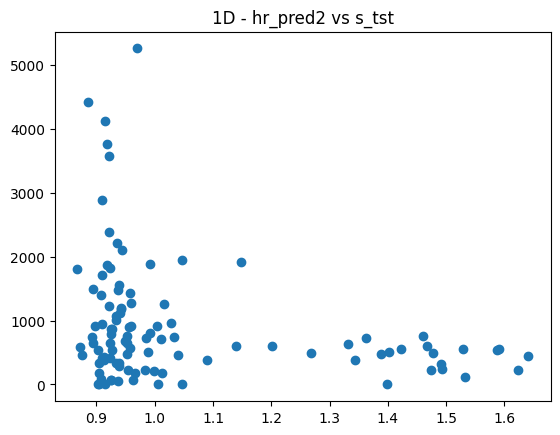

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 1, 128)        1408      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 1, 128)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               82048     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                           

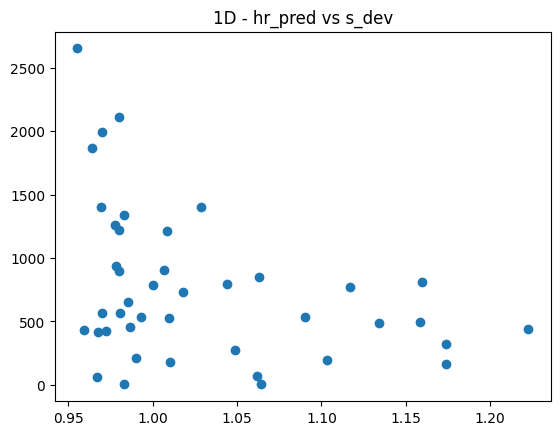

[[0.9763627 ]
 [0.9739357 ]
 [0.9685525 ]
 [0.95322156]
 [1.1287678 ]
 [0.99506694]
 [0.97539186]
 [0.97000104]
 [0.996929  ]
 [0.9762415 ]
 [0.95915866]
 [1.2054586 ]
 [1.0481077 ]
 [0.9793401 ]
 [0.98324066]
 [0.97535354]
 [0.984323  ]
 [1.041552  ]
 [0.9718247 ]
 [0.976567  ]
 [1.0247898 ]
 [0.99230266]
 [0.99413365]
 [0.9613406 ]
 [0.9847768 ]
 [0.9931884 ]
 [0.985638  ]
 [0.9895702 ]
 [0.97438616]
 [1.0712268 ]
 [1.1465187 ]
 [0.98871565]
 [0.96436113]
 [0.9750495 ]
 [0.98043674]
 [1.1102707 ]
 [0.97847533]
 [0.9718843 ]
 [0.97310674]
 [0.98200524]
 [1.17798   ]
 [1.1269063 ]
 [0.9984977 ]
 [0.97838986]
 [0.95975506]
 [1.1751056 ]
 [1.0941039 ]
 [0.9826905 ]
 [1.017468  ]
 [1.0791299 ]
 [1.1503627 ]
 [1.0524904 ]
 [0.9925413 ]
 [1.0075426 ]
 [0.96064276]
 [0.97440493]
 [1.0022726 ]
 [0.9697797 ]
 [1.0012382 ]
 [0.99158376]
 [0.98174256]
 [0.9978132 ]
 [1.0149837 ]
 [1.0205432 ]
 [1.0691284 ]
 [1.0799351 ]
 [0.9724275 ]
 [1.0076443 ]
 [1.0212666 ]
 [1.0920475 ]
 [0.9527159 ]
 [0.96

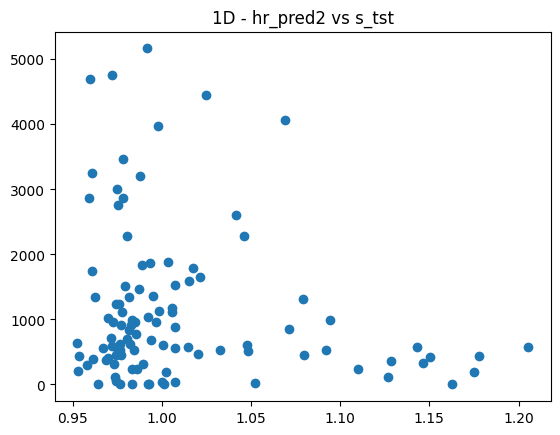

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 1, 128)        1408      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 1, 128)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               82048     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                           

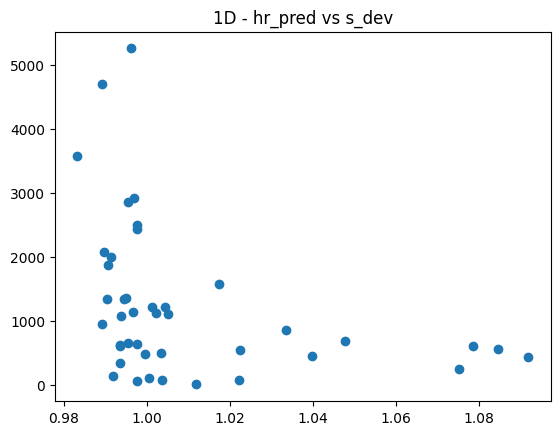

[[1.0175998 ]
 [0.99542296]
 [0.99980825]
 [0.99899757]
 [0.9921913 ]
 [0.99335694]
 [1.0528271 ]
 [1.0881456 ]
 [1.0597738 ]
 [1.078431  ]
 [0.99621505]
 [1.0042968 ]
 [0.9943579 ]
 [1.0065997 ]
 [0.98583734]
 [1.0404173 ]
 [0.99823576]
 [0.9897694 ]
 [1.0372924 ]
 [1.0199851 ]
 [1.0009056 ]
 [1.0758976 ]
 [1.0256208 ]
 [0.988749  ]
 [1.0829139 ]
 [0.99173176]
 [1.0205601 ]
 [1.0848953 ]
 [0.9992009 ]
 [1.0471357 ]
 [0.9891995 ]
 [0.994002  ]
 [0.99373394]
 [1.0078672 ]
 [1.005454  ]
 [0.994051  ]
 [0.9935817 ]
 [1.0025504 ]
 [0.9944065 ]
 [0.9930499 ]
 [0.99431235]
 [1.0039873 ]
 [0.9949445 ]
 [1.0133234 ]
 [0.99274254]
 [0.9904709 ]
 [0.9930788 ]
 [1.0104853 ]
 [0.98844564]
 [1.004774  ]
 [0.9898219 ]
 [0.99329746]
 [0.9836412 ]
 [1.0755576 ]
 [0.9930081 ]
 [0.9879284 ]
 [0.9939089 ]
 [1.0649743 ]
 [1.0063865 ]
 [0.9975165 ]
 [0.99792993]
 [1.0491806 ]
 [1.0128739 ]
 [0.98772633]
 [0.9934867 ]
 [1.002519  ]
 [0.99478257]
 [1.0149312 ]
 [1.0093999 ]
 [1.0062412 ]
 [0.99032867]
 [1.07

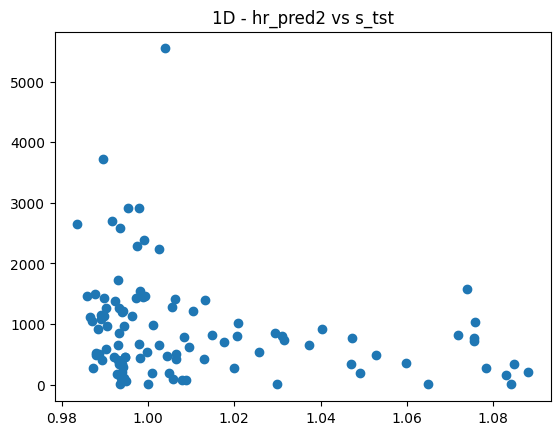

In [22]:
score_tst_list = []
score_dev_list = []

le, wi = 10,10
conv1_size=(1, le)
conv2_size=(wi, 1)
input_shape = (le, wi, 1)

# using just 1 loop for now
for i in range(0,1):
        ci_tst_list = []
        ci_dev_list = []
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        fold = 0
        for trn_index, tst_index in kf.split(X,E):
            fold +=1
            x_tst=X[tst_index]
            c_tst=E[tst_index]
            s_tst=Y[tst_index]

            x_trn, x_dev ,c_trn, c_dev , s_trn, s_dev=train_test_split(
                X[trn_index],E[trn_index],Y[trn_index],test_size=0.1,
                stratify=E[trn_index],random_state=1)

            sort_idx = np.argsort(s_trn)[::-1]
            x_trn = x_trn[sort_idx]
            s_trn = s_trn[sort_idx]
            c_trn = c_trn[sort_idx]

            x_trn = np.reshape(x_trn, (-1, le, wi))
            x_dev = np.reshape(x_dev, (-1, le, wi))
            x_tst = np.reshape(x_tst, (-1, le, wi))

            x_trn = x_trn.reshape(x_trn.shape[0], le, wi, 1)
            x_dev = x_dev.reshape(x_dev.shape[0], le, wi, 1)
            x_tst = x_tst.reshape(x_tst.shape[0], le, wi, 1)
        
            #fit
            data = (x_trn, c_trn, s_trn, x_dev, c_dev, s_dev)
            modelpath = save_path+"%s_fold_%s_repeat_%s_%s.hdf5" % (
                cancer_name,fold,i+1,le*wi)
            checkpoint = MyCallback(modelpath, data)
            
            
            

            
            
            #conv1=128
            #conv2=8
            #dense=32
            #input_img = Input(input_shape)
            #tower_1 = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            #tower_1 = MaxPooling2D(1, 2)(tower_1)
            #tower_1 = Flatten()(tower_1)
            #tower_2 = Conv2D(conv2, conv2_size, activation='relu')(input_img)
            #tower_2 = MaxPooling2D(1, 2)(tower_2)
            #tower_2 = Flatten()(tower_2)
            #output = concatenate([tower_1, tower_2], axis=1)
            #out1 = Dense(dense, activation='relu')(output)
            #last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out1)
            #model = Model(inputs=[input_img], outputs=last_layer)
            
            
            conv1=128
            dense=128
            input_img = Input(input_shape)
            tower = Conv2D(conv1, conv1_size, activation='relu')(input_img)
            tower1 = MaxPooling2D(1, 2)(tower)
            tower2 = Flatten()(tower1)
            out = Dense(dense, activation='relu')(tower2)
            last_layer = Dense(1, kernel_initializer='zeros', bias_initializer='zeros')(out)
            model = Model(inputs=[input_img], outputs=last_layer)

            
            
            
            model.compile(loss=[nll(c_trn, np.sum(c_trn))],
                          optimizer="adam")
            print(model.summary())
            
            print('Training...')
            history = model.fit(x_trn, s_trn, batch_size=len(x_trn),
                                epochs=100,verbose=0,callbacks=[checkpoint], shuffle=False)
            model.load_weights(modelpath)
        
            hr_pred=model.predict(x_dev,batch_size=1, verbose=0)
            hr_pred=np.exp(hr_pred)
            print(hr_pred)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred,s_dev)

            
            #log_pred = [-np.log(p) for p in hr_pred]
            #ax.scatter(hr_pred,log_pred)


            plt.title("1D - hr_pred vs s_dev")
            plt.show()
            ci_dev=concordance_index(s_dev,-hr_pred,c_dev)
            
            hr_pred2=model.predict(x_tst,batch_size=1, verbose=0)
            hr_pred2=np.exp(hr_pred2)
            print(hr_pred2)
            fig,ax = plt.subplots(1)
            ax.scatter(hr_pred2,s_tst)
            plt.title("1D - hr_pred2 vs s_tst")
            plt.show()
            ci_tst=concordance_index(s_tst,-hr_pred2,c_tst)
            
            ci_dev_list.append(ci_dev)
            ci_tst_list.append(ci_tst)
            
        score_dev_list.append(ci_dev_list)
        score_tst_list.append(ci_tst_list)


If the hazard ratio is less than 1, then the predictor is protective (i.e., associated with improved survival) and if the hazard ratio is greater than 1, then the predictor is associated with increased risk (or decreased survival).
